# Learning TD-Learning from "Neural" Activity

### Background
Let $l \in \{1,\ldots,L\}$ index trials and $t \in \{1, \ldots, T\}$ index time bin within a given trial. Let $S_{l,t}$ be the instantaneous stimulus (e.g. whether or not a light is shown in the $t$-th time bin of the $l$-th trial) and let $x_{l,t} \in \mathcal{R}^D$ be an encoding of the stimulus presented up to time $t$ in the $l$-th trial. That is, $x_{l,t}$ is an encoding of $S_{l,1:t}$. 

For TD-learning, the relevant signals are:


Value (scalar): 
$$ V_{l,t} = \mathbf{w}_l^{\sf T} \mathbf{x}_{l,t} $$

TD-error (scalar):
$$ \delta_{l,t} = r_{l,t+1} + \gamma V_{l,t+1} - V_{l,t} $$

Weights (vector in $\mathcal{R}^D$):
$$ \mathbf{w}_{l+1} = \mathbf{w}_l + \alpha_l \sum_{t=1}^T \delta_{l,t} \mathbf{x}_{l,t}$$

Here, the learning rate, $\alpha_l$, governs how much the weights change in the $l$-th trial.

For example, consider the experiment performed by Schultz et al. (1997): sensory stimuli are presented at time steps 10 and 20, and a reward is given at time step 60.  Time is encoded by standard basis functions. Over trials, the value is eventually shifted from the time of reward to the time of the first sensory cue.

### From Theory to Statistical Model
Now suppose that you know the reward signal, $r_{l,t}$, and that you can observe some cortical neurons that encode $x_{l,t}$ and some VTA neurons that encode $\delta_{l,t}$. Given our theory of TD-learning, what can we infer from these observations? Can we learn anything about the underlying weights, the learning rate, or the discount factor?  We will show how the theory of TD-learning can inform a state space model for neural activity and permit Bayesian inference of the weights, learning rates, and discount factors. 

The latent "state" of the model is the weight vector in each trial. Since our observations are bound to be noisy and incomplete, we will include a bit of noise in the weight dynamics:

$$ \mathbf{w}_{l+1} = \mathbf{w}_l + \alpha_l \sum_{t=1}^T \delta_{l,t} \mathbf{x}_{l,t} + \mathcal{N}(0, \eta I_D)$$

In standard state space notation, the weights have linear Gaussian dynamics:

$$ \mathbf{w}_{l+1} \sim \mathcal{N}(\mathbf{A} \mathbf{w}_l + \mathbf{b}_l, \; \eta I_D)$$

where $\mathbf{A}=I$ and $\mathbf{b}_l = \alpha_l \sum_{t=1}^T \delta_{l,t} \mathbf{x}_{l,t}$.
The only unknown terms in these dynamics are $\alpha_l$ and $\eta$, which we will infer. 

The observation will be the length-$(T-1)$ vector of prediction errors, $\mathbf{\delta}_{l,1:T-1} = [ \delta_{l,1}, \ldots, \delta_{l,T-1} ]$. Letting $\mathbf{x}_{l,1:T-1}$ and $\mathbf{x}_{l, 2:T}$ denote ${T-1 \times D}$ matrices, we can write the prediction error as:

$$ \mathbf{\delta}_{l,1:T-1} = \mathbf{r}_{l,2:T} + \gamma \mathbf{x}_{l,2:T} \mathbf{w}_l - \mathbf{x}_{l,1:T-1} \mathbf{w}_l + \mathcal{N}(0, \sigma I_T)$$
$$  = \mathbf{r}_{l,2:T} + (\gamma \mathbf{x}_{l,2:T} - \mathbf{x}_{l,1:T-1}) \mathbf{w}_l + \mathcal{N}(0, \sigma I_T)$$

As with the weight dynamics, we have allowed for some Gaussian noise in these observations. In state space notation, 

$$ \delta_{l,1:T-1} \sim \mathcal{N}(\mathbf{C}_l \mathbf{w}_l + \mathbf{d}_l, \; \sigma I_T), $$

where $\mathbf{C}_l = \gamma \mathbf{x}_{l,2:T} - \mathbf{x}_{l,1:T-1}$ and $\mathbf{d}_l = \mathbf{r}_{l,2:T}$. The only unknown parameters are $\gamma$ and $\sigma$, which we will infer. Given these parameters, the observations are a linear function of the latent weights.
Hence, our model for neural activity is a standard Gaussian linear dynamical system (LDS).

Note, however, that this is not just any LDS. We have imposed strong constraints on the dynamics and observation models -- constraints that are directly derived from the TD-learning theory. These constraints enable us to probe the data in a targeted fashion, and if the model fits well, we can justify our interpretations about the model parameters.

### Turning the Crank

Having formulated a Gaussian LDS for the neural activity, we can apply the tools of Bayesian inference to estimate parameters of interest. Namely,

- For fixed values of $\gamma$, $\alpha_l$, $\eta$ and $\sigma$, the (Gaussian) posterior distribution of weights can be found via the Kalman smoothing algorithm. 

- Since the value function is linear in the weights, the posterior distribution of the value function can be derived from the posterior of the weights.

- For fixed values of $\gamma$, $\alpha_l$, $\eta$ and $\sigma$, the marginal likelihood of the observed data (integrating out the weights) can be efficiently computed.

- For a given posterior distribution over weights, we can compute (in closed form) the values of $\alpha_l$ and $\eta$ that maximize the expected log likelihood.

- For a given posterior distribution over weights, we can compute (in closed form) the values of $\gamma$ and $\sigma$ that maximize the expected log likelihood.


Moreover, suppose we have two competing hypotheses for the learning rates -- say, hypothesis 1 is that the learning rate is constant and hypothesis 2 is that it decays according to a power law -- we can quantify the relative support for these hypotheses given the data. 

In [1]:
import copy 

import numpy as np
import numpy.random as npr
npr.seed(0)

from scipy.stats import norm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context("talk")
sns.set_style("white")

### Set up the experiment

In [2]:
L = 150                   # Number of trials
T = 60                    # Number of time steps
D = 20                    # Number of temporal basis fns / dim of weights

gamma = 0.99              # Discount factor
sigma_y = 0.05            # Observation noise
sigma_w = 0.01            # Weight dynamics noise
sigma_x = 0.0001          # Input noise

# Learning rate
# alpha = 0.75 * np.ones(L)            # Constant
alpha = (np.arange(L)+1.0)**(-0.5)  # Power law


Rs = np.zeros((L,T))      # Rewards
Rs[:,-1] = 1              # Always given in the last time step

S = np.zeros(T)           # Stimulus (same on each trial)
S[10] = 1.0               # Cue presented at times 10

S_scr = np.zeros((T,T))   # Serial compound representation : X[t,d] = S[t-d-1]
for t in range(T):        # One-hot encoding of preceding stimulus (zero padded)
    S_scr[t,:t+1] = S[:t+1][::-1] 


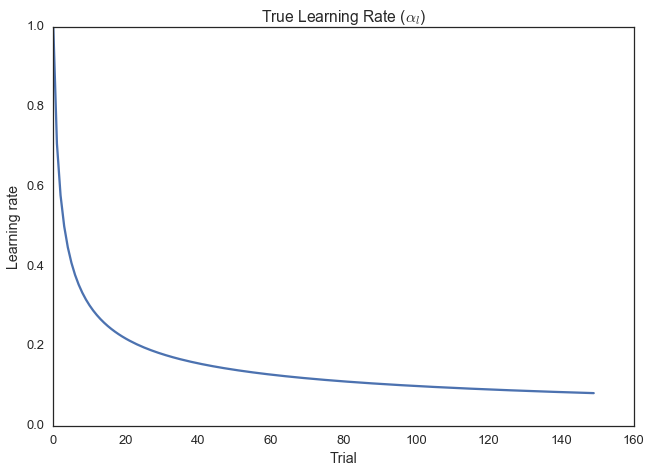

In [3]:
plt.plot(alpha)
plt.xlabel("Trial")
plt.ylabel("Learning rate")
plt.title("True Learning Rate ($\\alpha_l$)")

### Encode the stimulus with a population of neurons with  Gaussian tuning curves

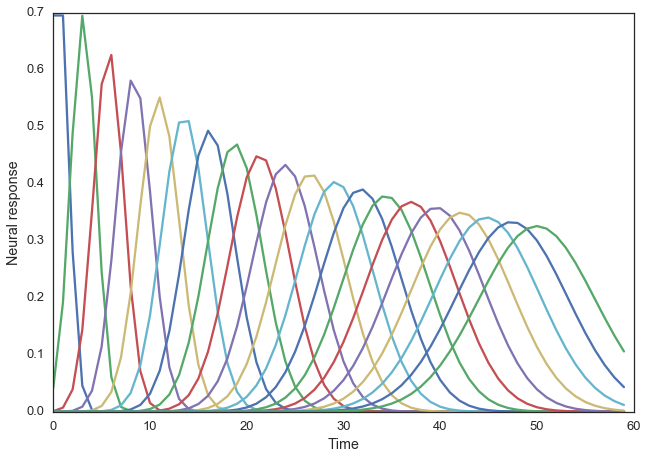

In [4]:
# Encode the stimulus with a population of neurons with 
# Gaussian tuning curves.

# Uniformly spaced with increasing width
mu = np.linspace(0.5, T-10, D)
sig = 1.0 +  5.0 / (T-10) * mu

# Normalization
Z = np.log(2.0) -0.5 * np.log(2 * np.pi * sig)

# Compute the firing rate of neuron n
basis = lambda d, t: np.exp(Z[d] - 0.5/sig[d]**2 * (t-mu[d])**2)

F = np.zeros((T, D))
for d in range(D):
    F[:,d] = basis(d, np.arange(T))
    
# Project serial compound representation onto basis
X = S_scr.dot(F)

# HACK: Set last encoding to zero to force V[T] = 0
X[-1] = 0
 
# Each time step gets a noise version of X
Xs = np.array([X + sigma_x * npr.randn(*X.shape) 
               for l in range(L)])
    
plt.plot(F)
plt.xlabel("Time")
plt.ylabel("Neural response")

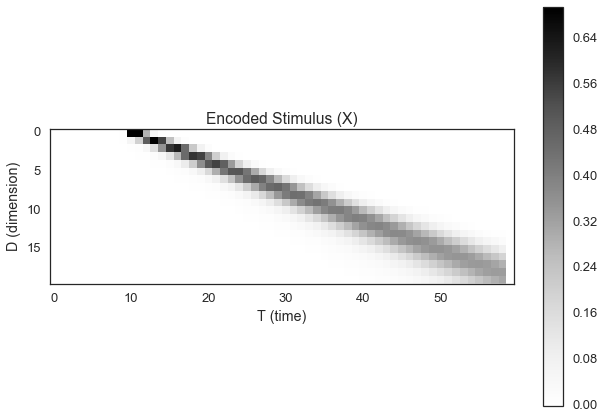

In [5]:
plt.imshow(X.T, interpolation="none", cmap="Greys")
plt.xlabel("T (time)")
plt.ylabel("D (dimension)")
plt.title("Encoded Stimulus (X)")
plt.colorbar()

### Simulate some data!

In [6]:
def simulate_vectorized(Xs, Rs, alpha, gamma, sigma_y, sigma_w, W0=0):
    L, T, D = Xs.shape
    assert Rs.shape == (L,T)
    assert alpha.shape == (L,)
    assert np.isscalar(gamma)
    assert np.isscalar(W0) or W0.shape == (D,)
    
    # Initialize outputs
    Vs = np.zeros((L, T))      # Values
    Ws = np.zeros((L, D))      # Weights
    deltas = np.zeros((L, T))  # TD errors
    Ys = np.zeros((L,T))       # Noisy TD errors
    
    Ws[0] = W0
    
    # Run the TD-Learning algorithm
    for l in range(L):
        # Compute the value function for each time bin
        Vs[l] = Xs[l].dot(Ws[l])
        
        # Compute prediction error for first T-1 bins
        deltas[l,:-1] = Rs[l,1:] + gamma * Vs[l,1:] - Vs[l,:-1]
        Ys[l,:-1] = deltas[l,:-1] + sigma_y * npr.randn(T-1)
        
        # Update weights post trial        
        dw = alpha[l] * Ys[l,:-1].dot(Xs[l,:-1])
        if l < L-1:
            Ws[l+1] = Ws[l] + dw + sigma_w * npr.randn(D)
                
    return Vs, Ws, deltas, Ys

In [7]:
# Run the TD Learning algorithm 
Vs, Ws, deltas, Ys = simulate_vectorized(Xs, Rs, alpha, gamma, sigma_y, sigma_w)

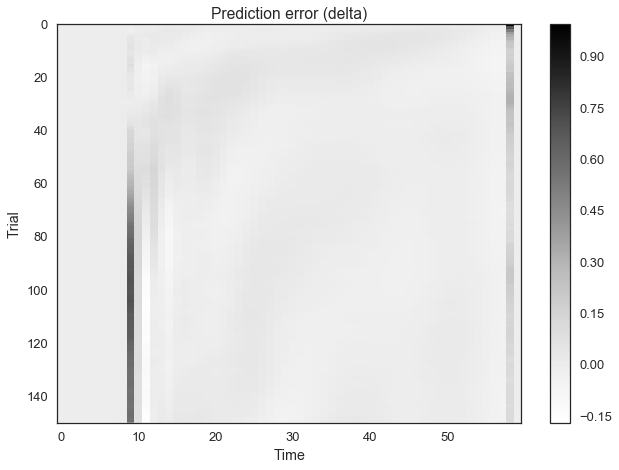

In [8]:
# Look at the error signal
# Compare to Fig 3 (top) of Schultz et al
plt.imshow(deltas, aspect="auto", interpolation="none")
plt.xlabel("Time")
plt.ylabel("Trial")
plt.title("Prediction error (delta)")
plt.colorbar()

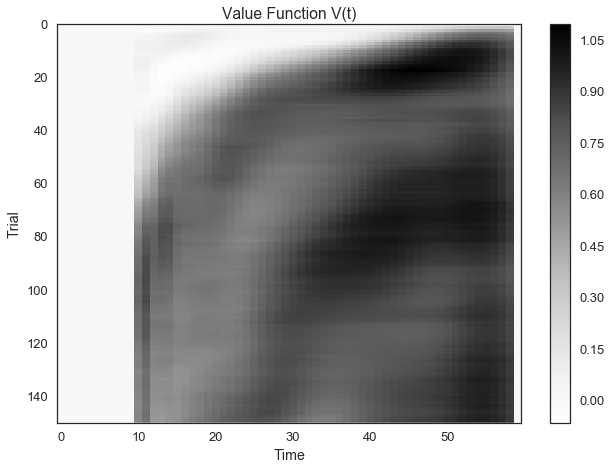

In [9]:
# Visualize the value function 
# Compare to Fig 3 (bottom) of Schultz et al
plt.imshow(Vs, aspect="auto", interpolation="none")
plt.xlabel("Time")
plt.ylabel("Trial")
plt.title("Value Function V(t)")
plt.colorbar()

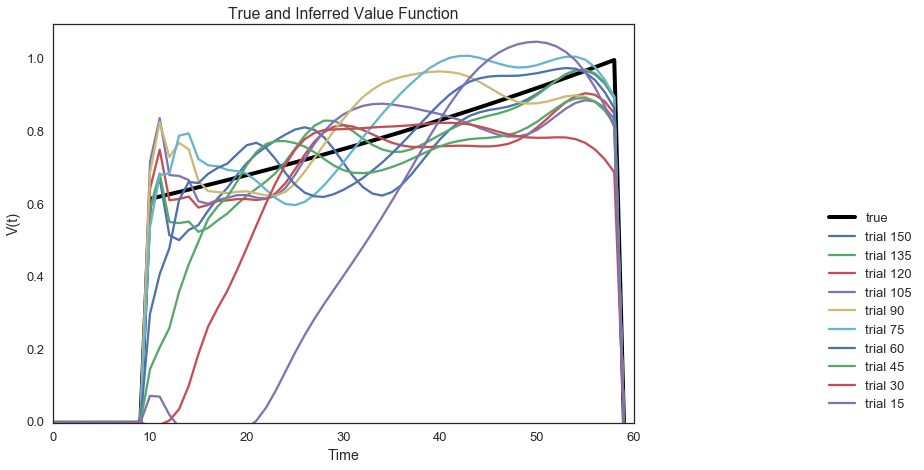

In [10]:
# Plot the true discounted sum of future reward
V_true = np.zeros(T)
V_true[10:-1] = gamma**np.arange(49)[::-1]
plt.plot(V_true, '-k', lw=4, label="true")

# Plot the inferred value functions at different iterations
for l in range(L-1,-1,-L//10):
    plt.plot(Vs[l,:], label="trial {}".format(l+1))


plt.ylim(0,1.1)
plt.ylabel("V(t)")
plt.xlabel("Time")
plt.title("True and Inferred Value Function")
plt.legend(loc="lower right", bbox_to_anchor=(1.5,0,0,0))


# Joint inference of Weights _and_ Learning Rate 

In [11]:
from pybasicbayes.util.text import progprint_xrange
from pylds.lds_messages_interface import rts_smoother

The E-step is the same for both learning rate models

In [12]:
def E_step(Y, Xn, Rs, params):
    mu_init = params["mu_init"] * np.ones((D))
    sigma_init = params["sigma_init"] * np.eye(D)

    A = np.eye(D)
    Bs = np.array(
            [(params["alpha"][l] * Y[l].dot(Xn[l])).reshape((D,1)) 
              for l in range(L)])

    sigma_w = params["sigma_w"] * np.eye(D)

    # Due to the TD learning rule, we have to 
    # handle the last time bin explicitly
    Cs = np.array(
            [np.vstack([(params["gamma"] * Xn[l,1:] - Xn[l,:-1]), np.zeros((1,D))]) 
             for l in range(L)])

    Ds = np.array(
            [np.vstack([Rs[l,1:][:,None], np.zeros((1,1))])
             for l in range(L)])

    sigma_y = params["sigma_y"] * np.eye(T)

    # Constant inputs 
    U = np.ones((L,1))
    
    # Compute expected weight trajectory
    ll, mu_W, Var_W = \
    rts_smoother(mu_init, sigma_init, 
                 A, Bs, sigma_w,
                 Cs, Ds, sigma_y,
                 U, Y.copy("C"))

    # Package outputs
    expectations = dict(ll=ll, mu_W=mu_W, Var_W=Var_W)
    return expectations

The M-step for $\gamma$ is the same for both models, but the M-step for the learning rate differs.

In [13]:
def M_step_gamma(Y, Xn, Rs, params, expectations):
    """
    Likewise, the optimal discount factor can also be computed in 
    closed form. The derivation is quite similar, but it involves a quadratic
    term in W. 
    """
    mu_W = expectations["mu_W"]
    Var_W = expectations["Var_W"]
    E_WWT = np.array([Var_W[l] + np.outer(mu_W[l], mu_W[l]) for l in range(L)])
    
    al = np.zeros(L)
    bl = np.zeros(L)
    for l in range(L):
        Xl = Xn[l][:-1]
        Xlp1 = Xn[l][1:]
        
        al[l] = np.trace(Xlp1.T.dot(Xlp1).dot(E_WWT[l]))
        bl[l] = (Y[l][:-1] - Rs[l][1:]).dot(Xlp1).dot(mu_W[l])
        bl[l] += np.trace(Xl.T.dot(Xlp1).dot(E_WWT[l]))
                 
    return np.sum(bl) / np.sum(al)
        
def M_step_alpha(Y, Xn, Rs, params, expectations):
    """
    The learning rate that maximizes the expected log likelihood
    can be computed in closed form. We have
    
    \hat{a} = argmax E_q(W)[log p(W | a, X, delta)]
            = argmax E_q(W)[\sum_{l=1}^{L-1} -1/2\eta (W_{l+1} - W_{l} - a * b_{l})**2]
       
    where b_{l} = \sum_{t} \delta_{l,t} x_{l,t}
    
    The solution to this problem is,
    
    \hat{a} = [\sum_{l} (E[W_{l+1} - E[W_{l}]) \dot b_{l}] / [\sum_{l} b_{l} \dot b_{l}]
    
    """
    mu_W = expectations["mu_W"]
    
    # Compute b and change in W
    b = np.array([Y[l].dot(Xn[l]) for l in range(L-1)])
    dW = mu_W[1:] - mu_W[:-1]
    
    # Compute optimal a
    return np.sum(dW * b) / np.sum(b * b) * np.ones(L)


def M_step_tau(Y, Xn, Rs, params, expectations):
    """
    For power-law learning rates, we cannot solve for the optimal tau
    exactly. Instead, we'll just run BFGS to optimize the expected 
    log likelihood.
    """
    from scipy.optimize import minimize_scalar

    mu_W = expectations["mu_W"]
    def _neg_expected_log_lkhd(tau):
        ell = 0

        alpha = (np.arange(L) + 1.0)**(-tau)
        for l in range(L-1):
            dWl = alpha[l] * Y[l,:-1].dot(Xn[l,:-1])
            ell += -0.5/params["sigma_w"]**2 * np.sum((mu_W[l+1] - mu_W[l] - dWl)**2)
    
        return -1.0 * ell
    
    res = minimize_scalar(_neg_expected_log_lkhd, bounds=(0,1))
    tau = res.x
    return (np.arange(L) + 1.0)**(-tau)
    
def M_step_constant(Y, Xn, Rs, params, expectations):
    # Update params
    params = copy.deepcopy(params)
    params["alpha"] = M_step_alpha(Y, Xn, Rs, params, expectations)
    params["gamma"] = M_step_gamma(Y, Xn, Rs, params, expectations)
    
    return params

def M_step_powerlaw(Y, Xn, Rs, params, expectations):
    # Update params
    params = copy.deepcopy(params)
    params["alpha"] = M_step_tau(Y, Xn, Rs, params, expectations)
    params["gamma"] = M_step_gamma(Y, Xn, Rs, params, expectations)
    
    return params


# Fit a model with a constant learning rate

In [14]:
# Initialize parameters
params = dict(alpha=1.5 * np.ones(L),
              gamma=0.5,
              sigma_w=sigma_w,
              sigma_y=sigma_y,
              mu_init=0,
              sigma_init=1.0)

# Run the EM algorithm
N_iter = 50
all_params = [params]
all_expectations = []

for itr in progprint_xrange(N_iter):
    expectations = E_step(Ys, Xs, Rs, params)
    all_expectations.append(expectations)

    params = M_step_constant(Ys, Xs, Rs, params, expectations)
    all_params.append(params)
    
lls_cnst = np.array([e["ll"] for e in all_expectations])
inf_alpha_cnst = np.array([p["alpha"] for p in all_params])
inf_gamma_cnst = np.array([p["gamma"] for p in all_params])

.........................  [ 25/50,    0.02sec avg, ETA 0.60 ]
.........................  [ 50/50,    0.02sec avg, ETA 0.00 ]

   0.02sec avg, 1.19 total



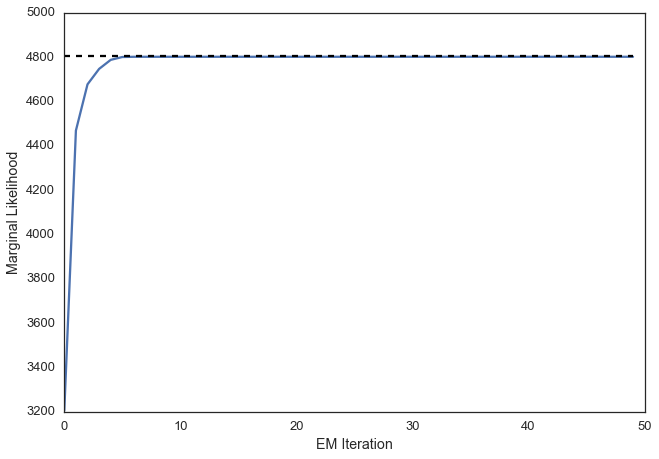

In [15]:
true_params = dict(alpha=alpha,
                   gamma=gamma,
                   sigma_w=sigma_w,
                   sigma_y=sigma_y,
                   mu_init=0,
                   sigma_init=1.0)
true_expectations = E_step(Ys, Xs, Rs, true_params)

plt.plot(lls_cnst)
plt.plot(true_expectations["ll"] * np.ones(N_iter), '--k')
plt.xlabel("EM Iteration")
plt.ylabel("Marginal Likelihood")

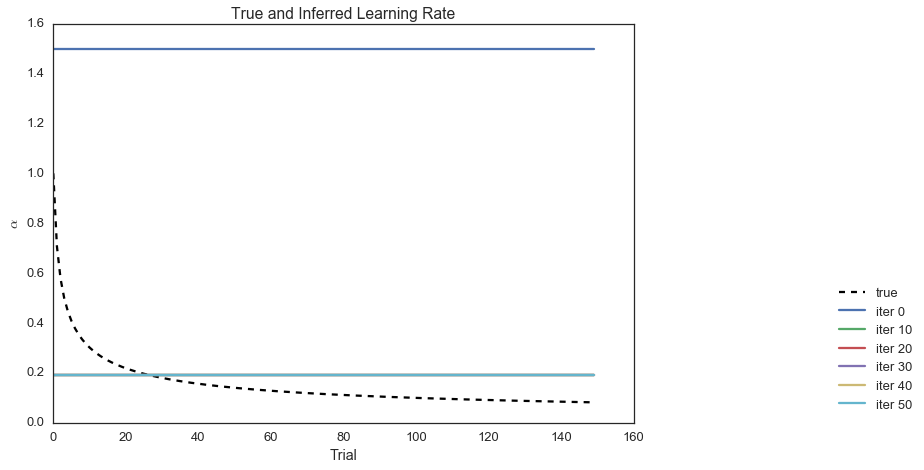

In [16]:
plt.plot(alpha, '--k', label="true")

for itr in range(0,N_iter+1,10):
    plt.plot(inf_alpha_cnst[itr], label="iter {}".format(itr))

plt.xlabel("Trial")
plt.ylabel("$\\alpha$")
plt.title("True and Inferred Learning Rate")

plt.legend(loc="lower right", bbox_to_anchor=(1.5,0,0,0))

_Notice that the constant learning rate has to strike a balance at around $\alpha=0.2$ since it cannot capture the true power law behavior!_

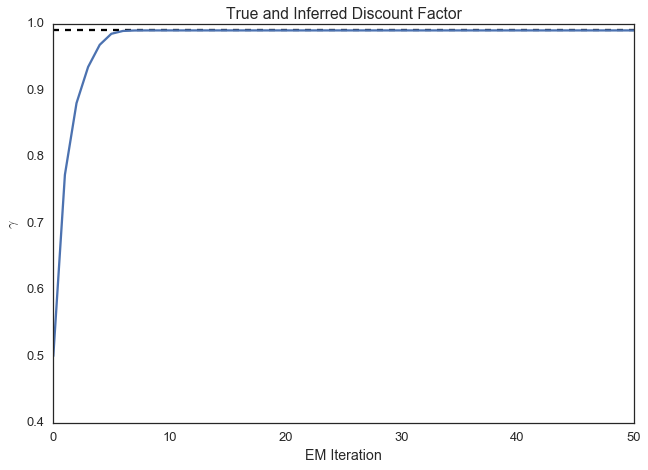

In [17]:
plt.plot(gamma * np.ones(N_iter+1), '--k')
plt.plot(inf_gamma_cnst)
plt.xlabel("EM Iteration")
plt.ylabel("$\\gamma$")
plt.title("True and Inferred Discount Factor")

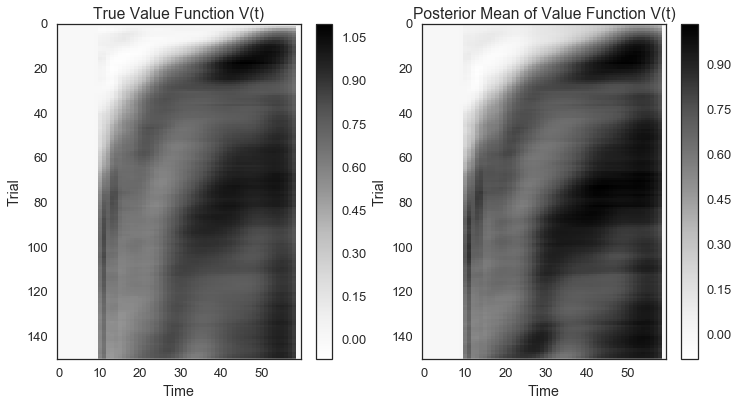

In [18]:
# Compute smoothed estimates of V and delta
cnst_mu_W = expectations["mu_W"]
cnst_Var_W = expectations["Var_W"]

cnst_mu_V = np.array([cnst_mu_W[l].dot(Xs[l].T) for l in range(L)])
cnst_sigmasq_V = np.array([np.diag(Xs[l].dot(cnst_Var_W[l]).dot(Xs[l].T)) 
                      for l in range(L)])

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(Vs, aspect="auto", interpolation="none")
plt.xlabel("Time")
plt.ylabel("Trial")
plt.title("True Value Function V(t)")
plt.colorbar()

plt.subplot(122)
plt.imshow(cnst_mu_V, aspect="auto", interpolation="none")
plt.xlabel("Time")
plt.ylabel("Trial")
plt.title("Posterior Mean of Value Function V(t)")
plt.colorbar()

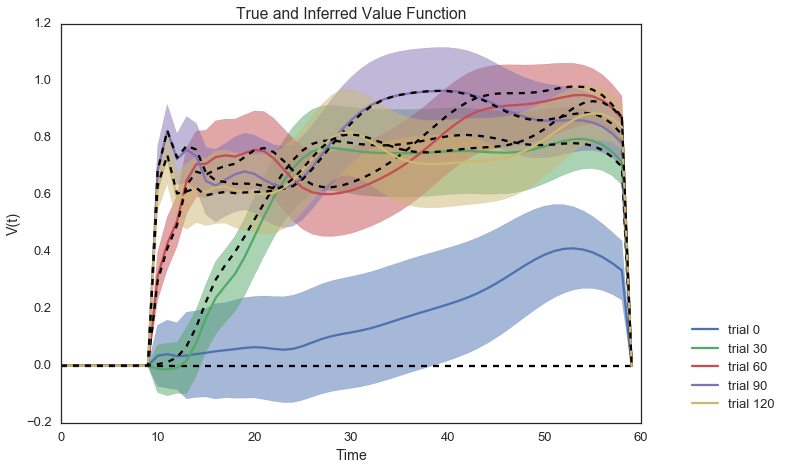

In [19]:
# Plot slices of the value function with marginal variance
from hips.plotting.sausage import sausage_plot
for l in range(0, L, L//5):
    ln = plt.plot(cnst_mu_V[l], label="trial {}".format(l))
    sausage_plot(np.arange(T), cnst_mu_V[l], np.sqrt(cnst_sigmasq_V[l]), 
                 color=ln[0].get_color(), alpha=0.5)
    plt.plot(Vs[l], '--k')

# plt.ylim(0,1.2)
plt.ylabel("V(t)")
plt.xlabel("Time")
plt.title("True and Inferred Value Function")
plt.legend(loc="lower right", bbox_to_anchor=(1.25,0,0,0))

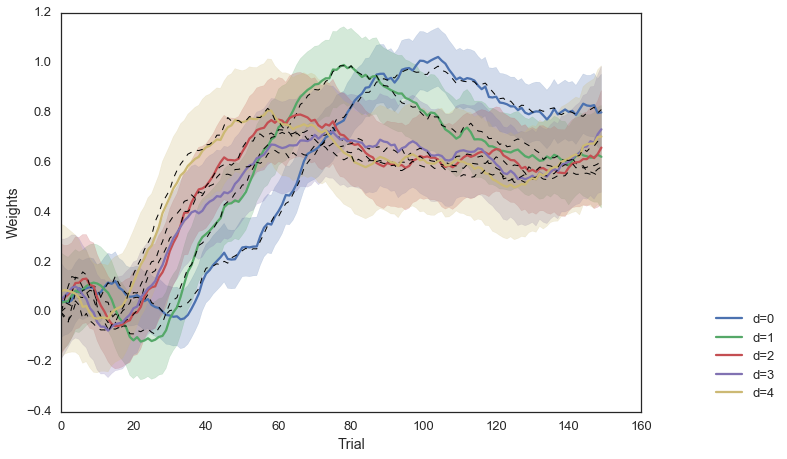

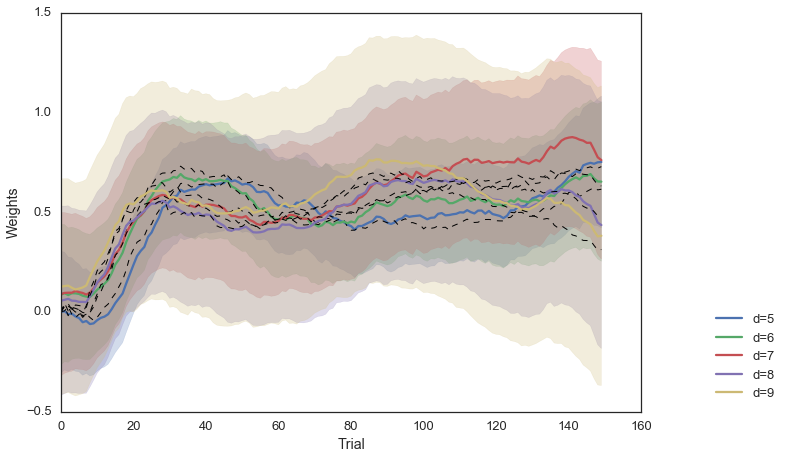

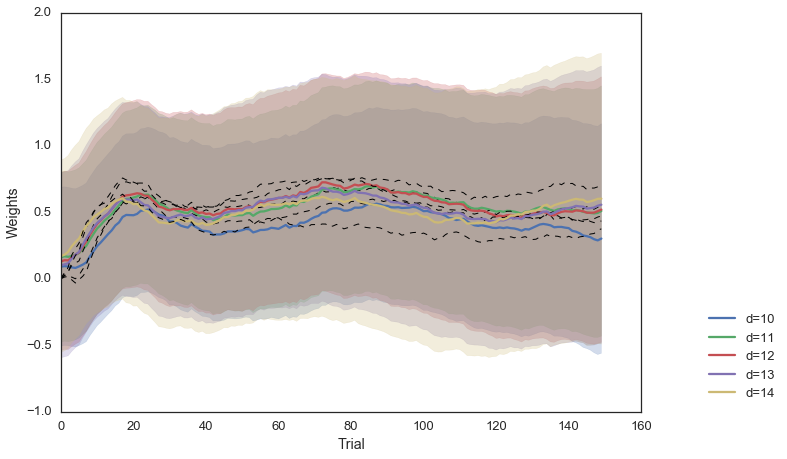

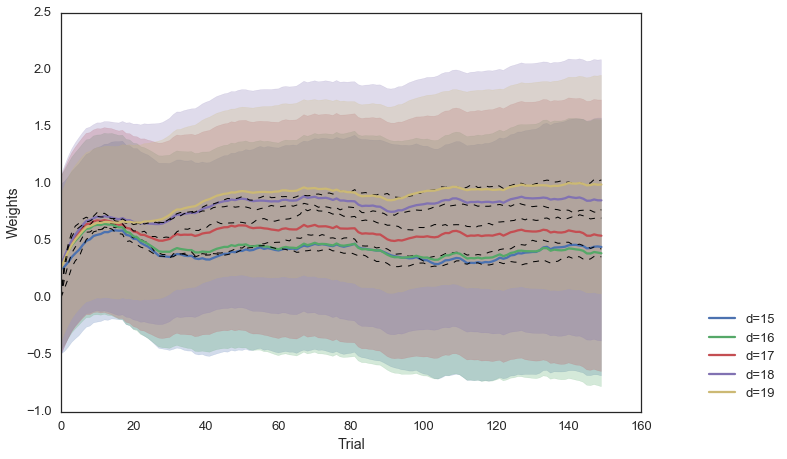

In [20]:
from hips.plotting.sausage import sausage_plot
mu_W = expectations["mu_W"]
Var_W = expectations["Var_W"]

for offset in range(0,D,5):
    plt.figure()
    
    for d in range(offset, offset+5):
        ln = plt.plot(mu_W[:,d], label="d={}".format(d))
        sausage_plot(np.arange(L), mu_W[:,d], np.sqrt(Var_W[:,d,d]), 
                     color=ln[0].get_color(), alpha=0.25)
        plt.plot(Ws[:,d], '--k', lw=1)

    plt.xlabel("Trial")
    plt.ylabel("Weights")
    plt.legend(loc="lower right", bbox_to_anchor=(1.25,0,0,0))

# Fit a model with a power-law learning rate

In [21]:
# Initialize parameters
params = dict(alpha=np.ones(L),
              gamma=0.5,
              sigma_w=sigma_w,
              sigma_y=sigma_y,
              mu_init=0,
              sigma_init=1.0)

# Run the EM algorithm
N_iter = 50
all_params = [params]
all_expectations = []

for itr in progprint_xrange(N_iter):
    expectations = E_step(Ys, Xs, Rs, params)
    all_expectations.append(expectations)

    params = M_step_powerlaw(Ys, Xs, Rs, params, expectations)
    all_params.append(params)
    
lls_pwr = np.array([e["ll"] for e in all_expectations])
inf_alpha_pwr = np.array([p["alpha"] for p in all_params])
inf_gamma_pwr = np.array([p["gamma"] for p in all_params])

.........................  [ 25/50,    0.05sec avg, ETA 1.32 ]
.........................  [ 50/50,    0.06sec avg, ETA 0.00 ]

   0.06sec avg, 2.79 total



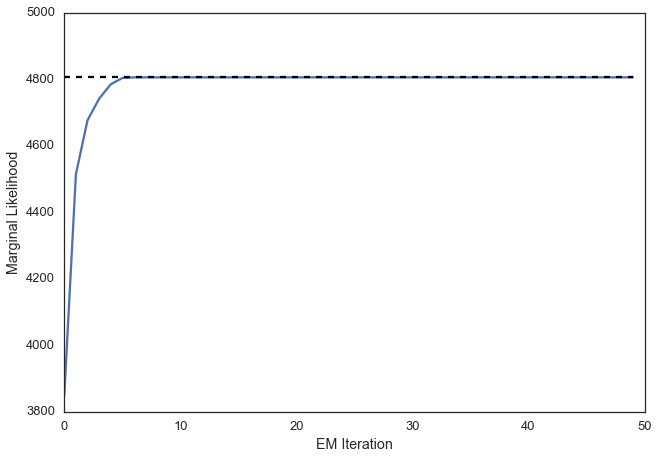

In [22]:
true_params = dict(alpha=alpha,
                   gamma=gamma,
                   sigma_w=sigma_w,
                   sigma_y=sigma_y,
                   mu_init=0,
                   sigma_init=1.0)
true_expectations = E_step(Ys, Xs, Rs, true_params)

plt.plot(lls_pwr)
plt.plot(true_expectations["ll"] * np.ones(N_iter), '--k')
plt.xlabel("EM Iteration")
plt.ylabel("Marginal Likelihood")

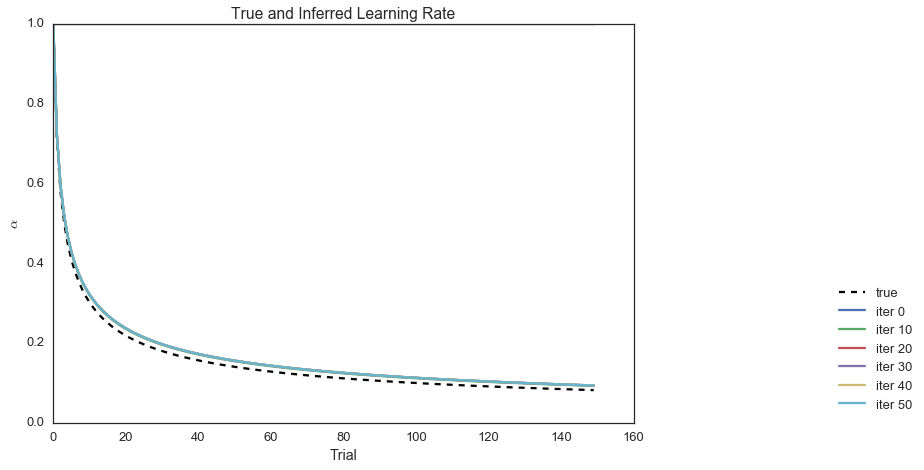

In [23]:
plt.plot(alpha, '--k', label="true")

for itr in range(0,N_iter+1,10):
    plt.plot(inf_alpha_pwr[itr], label="iter {}".format(itr))

plt.xlabel("Trial")
plt.ylabel("$\\alpha$")
plt.title("True and Inferred Learning Rate")

plt.legend(loc="lower right", bbox_to_anchor=(1.5,0,0,0))

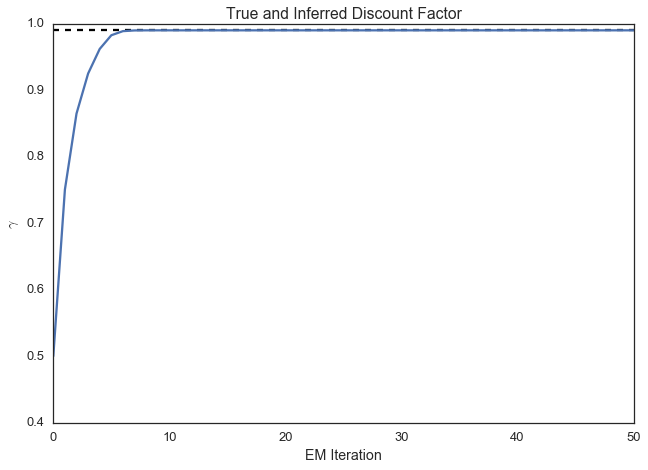

In [24]:
plt.plot(gamma * np.ones(N_iter+1), '--k')
plt.plot(inf_gamma_pwr)
plt.xlabel("EM Iteration")
plt.ylabel("$\\gamma$")
plt.title("True and Inferred Discount Factor")

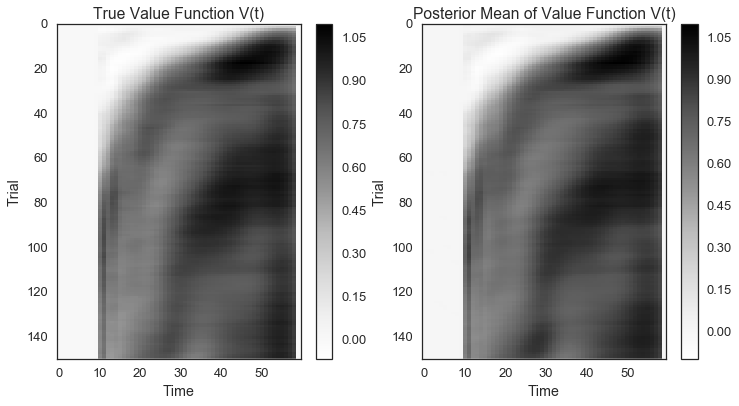

In [25]:
# Compute smoothed estimates of V and delta
pwr_mu_W = expectations["mu_W"]
pwr_Var_W = expectations["Var_W"]

pwr_mu_V = np.array([pwr_mu_W[l].dot(Xs[l].T) for l in range(L)])
pwr_sigmasq_V = np.array([np.diag(Xs[l].dot(pwr_Var_W[l]).dot(Xs[l].T)) 
                      for l in range(L)])

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(Vs, aspect="auto", interpolation="none")
plt.xlabel("Time")
plt.ylabel("Trial")
plt.title("True Value Function V(t)")
plt.colorbar()

plt.subplot(122)
plt.imshow(pwr_mu_V, aspect="auto", interpolation="none")
plt.xlabel("Time")
plt.ylabel("Trial")
plt.title("Posterior Mean of Value Function V(t)")
plt.colorbar()

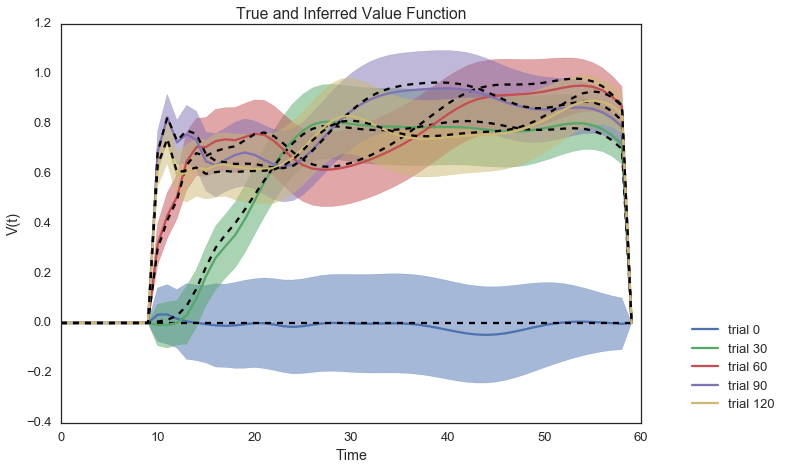

In [26]:
# Plot slices of the value function with marginal variance
from hips.plotting.sausage import sausage_plot
for l in range(0, L, L//5):
    ln = plt.plot(pwr_mu_V[l], label="trial {}".format(l))
    sausage_plot(np.arange(T), pwr_mu_V[l], np.sqrt(pwr_sigmasq_V[l]), 
                 color=ln[0].get_color(), alpha=0.5)
    plt.plot(Vs[l], '--k')

# plt.ylim(0,1.2)
plt.ylabel("V(t)")
plt.xlabel("Time")
plt.title("True and Inferred Value Function")
plt.legend(loc="lower right", bbox_to_anchor=(1.25,0,0,0))

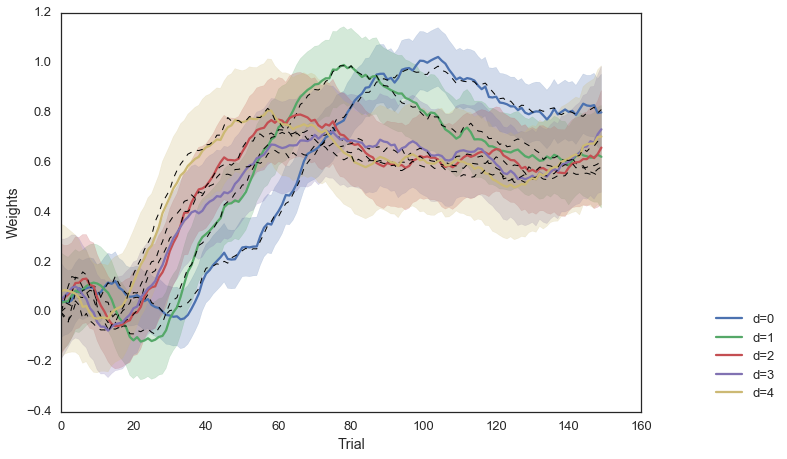

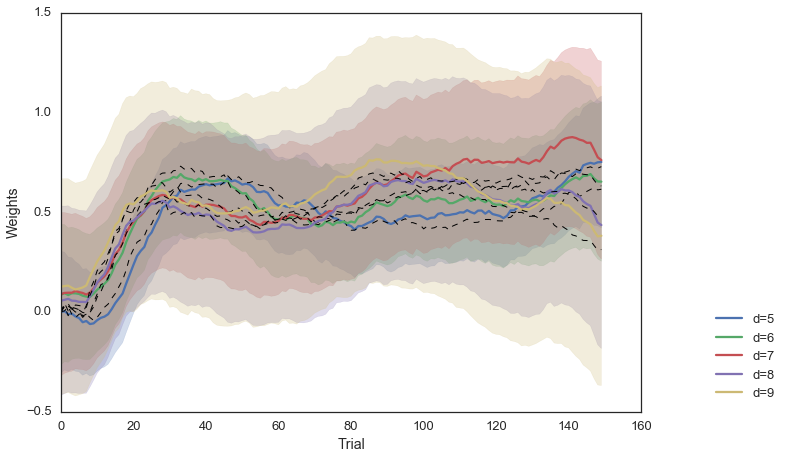

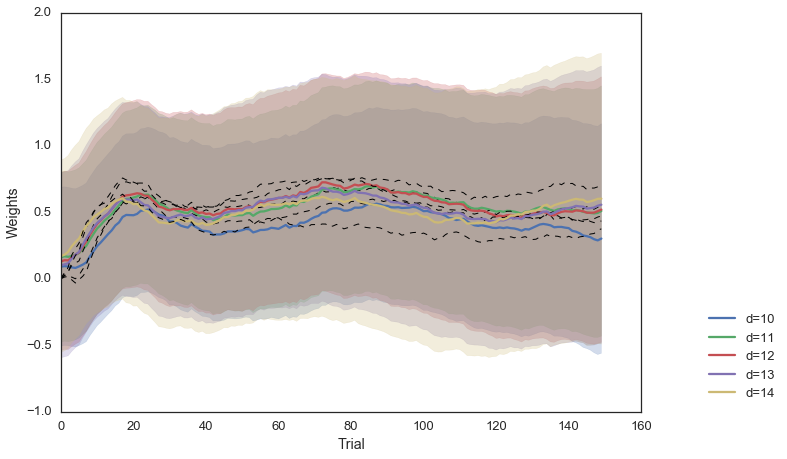

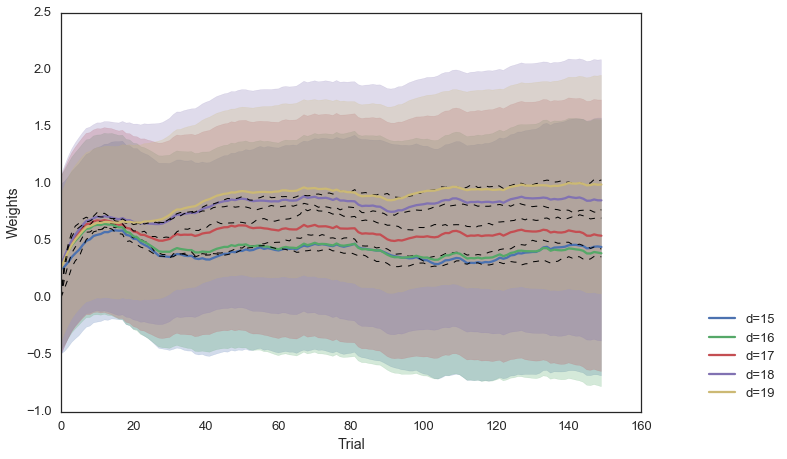

In [27]:
from hips.plotting.sausage import sausage_plot
pwr_mu_W = expectations["mu_W"]
pwr_Var_W = expectations["Var_W"]

for offset in range(0,D,5):
    plt.figure()
    
    for d in range(offset, offset+5):
        ln = plt.plot(mu_W[:,d], label="d={}".format(d))
        sausage_plot(np.arange(L), mu_W[:,d], np.sqrt(Var_W[:,d,d]), 
                     color=ln[0].get_color(), alpha=0.25)
        plt.plot(Ws[:,d], '--k', lw=1)

    plt.xlabel("Trial")
    plt.ylabel("Weights")
    plt.legend(loc="lower right", bbox_to_anchor=(1.25,0,0,0))

# Compute the Marginal Likelihood of Two Learning Rules

### Hypothesis 1: Constant Learning Rate
Suppose $\alpha_l = c$ where $c \sim \mathrm{Unif}(0,1)$.

### Hypothesis 2: Power law Learning Rate
Suppose $\alpha_l = (l + 1)^{- \tau}$ where $\tau \sim \mathrm{Unif}(0,1)$.



In [28]:
from scipy.misc import logsumexp

In [29]:
N_bins = 1000
edges = np.linspace(0, 1, N_bins+1)
bin_size = edges[1] - edges[0]
c_mids = (edges[1:] + edges[:-1]) / 2.0
lls_H1 = np.zeros(N_bins)

for i in progprint_xrange(N_bins, perline=40):
    params = dict(alpha=c_mids[i]*np.ones(L),
                  gamma=gamma,
                  sigma_w=sigma_w,
                  sigma_y=sigma_y,
                  mu_init=0,
                  sigma_init=1.0)
    expectations = E_step(Ys, Xs, Rs, params)
    lls_H1[i] = expectations["ll"] + np.log(bin_size)
    
    if not np.isfinite(lls_H1[i]):
        lls_H1[i] = -np.inf
        
marg_lkhd_H1 = logsumexp(lls_H1)

........................................  [   40/1000,    0.02sec avg, ETA 15.76 ]
........................................  [   80/1000,    0.02sec avg, ETA 14.25 ]
........................................  [  120/1000,    0.02sec avg, ETA 13.46 ]
........................................  [  160/1000,    0.02sec avg, ETA 12.96 ]
........................................  [  200/1000,    0.02sec avg, ETA 12.54 ]
........................................  [  240/1000,    0.02sec avg, ETA 12.01 ]
........................................  [  280/1000,    0.02sec avg, ETA 11.33 ]
........................................  [  320/1000,    0.02sec avg, ETA 10.81 ]
........................................  [  360/1000,    0.02sec avg, ETA 10.24 ]
........................................  [  400/1000,    0.02sec avg, ETA 9.60 ]
........................................  [  440/1000,    0.02sec avg, ETA 9.08 ]
........................................  [  480/1000,    0.02sec avg, ETA 8.43 ]
.......

In [30]:
N_bins = 1000
edges = np.linspace(0, 1, N_bins+1)
bin_size = edges[1] - edges[0]
tau_mids = (edges[1:] + edges[:-1]) / 2.0
lls_H2 = np.zeros(N_bins)

for i in progprint_xrange(N_bins, perline=40):
    params = dict(alpha=(np.arange(L) + 1.0)**(-tau_mids[i]),
                  gamma=gamma,
                  sigma_w=sigma_w,
                  sigma_y=sigma_y,
                  mu_init=0,
                  sigma_init=1.0)
    expectations = E_step(Ys, Xs, Rs, params)
    lls_H2[i] = expectations["ll"] + np.log(bin_size)
    
    if not np.isfinite(lls_H2[i]):
        lls_H2[i] = -np.inf
        
marg_lkhd_H2 = logsumexp(lls_H2)

........................................  [   40/1000,    0.02sec avg, ETA 15.77 ]
........................................  [   80/1000,    0.02sec avg, ETA 14.01 ]
........................................  [  120/1000,    0.01sec avg, ETA 12.99 ]
........................................  [  160/1000,    0.01sec avg, ETA 12.37 ]
........................................  [  200/1000,    0.01sec avg, ETA 11.66 ]
........................................  [  240/1000,    0.01sec avg, ETA 11.35 ]
........................................  [  280/1000,    0.01sec avg, ETA 10.72 ]
........................................  [  320/1000,    0.01sec avg, ETA 10.12 ]
........................................  [  360/1000,    0.02sec avg, ETA 9.71 ]
........................................  [  400/1000,    0.02sec avg, ETA 9.30 ]
........................................  [  440/1000,    0.02sec avg, ETA 8.71 ]
........................................  [  480/1000,    0.02sec avg, ETA 8.15 ]
........

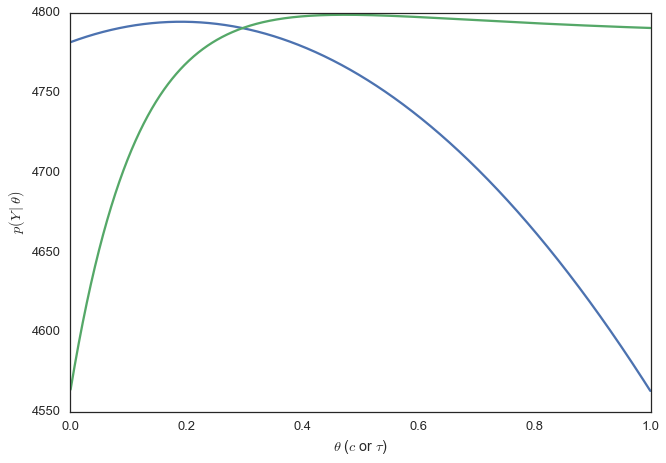

In [31]:
plt.plot(c_mids, lls_H1)
plt.plot(tau_mids, lls_H2)
plt.xlabel("$\\theta$ ($c$ or $\\tau$)")
plt.ylabel("$p(Y \\mid \\theta)$")


In [32]:
print("ML 1:  ", marg_lkhd_H1)
print("ML 2:  ", marg_lkhd_H2)
print("BF 1v2: ", np.exp(marg_lkhd_H1 - marg_lkhd_H2))
print("BF 2v1: ", np.exp(marg_lkhd_H2 - marg_lkhd_H1))

ML 1:   4798.89892184
ML 2:   4803.78314249
BF 1v2:  0.00756501728342
BF 2v1:  132.187404541


**This is what we want! Since the data is truly drawn from a model with a power law learning rate, we expect H2 to be much more likely than H1**

# Fit an Unstructured LDS to the data

In [33]:
from pylds.models import DefaultLDS

In [34]:
lds = DefaultLDS(T, D, D_input=1, sigma_init=0.01*np.eye(D))
lds.add_data(Ys, inputs=np.ones((L, 1)))

lds_lls = []
for itr in progprint_xrange(500):
    lds.EM_step()
    lds_lls.append(lds.log_likelihood())

.........................  [  25/500,    0.01sec avg, ETA 6.54 ]
.........................  [  50/500,    0.01sec avg, ETA 5.43 ]
.........................  [  75/500,    0.01sec avg, ETA 4.80 ]
.........................  [ 100/500,    0.01sec avg, ETA 4.41 ]
.........................  [ 125/500,    0.01sec avg, ETA 4.02 ]
.........................  [ 150/500,    0.01sec avg, ETA 3.71 ]
.........................  [ 175/500,    0.01sec avg, ETA 3.42 ]
.........................  [ 200/500,    0.01sec avg, ETA 3.13 ]
.........................  [ 225/500,    0.01sec avg, ETA 2.84 ]
.........................  [ 250/500,    0.01sec avg, ETA 2.56 ]
.........................  [ 275/500,    0.01sec avg, ETA 2.29 ]
.........................  [ 300/500,    0.01sec avg, ETA 2.02 ]
.........................  [ 325/500,    0.01sec avg, ETA 1.76 ]
.........................  [ 350/500,    0.01sec avg, ETA 1.50 ]
.........................  [ 375/500,    0.01sec avg, ETA 1.25 ]
.........................

**The LDS can fit the data very well, but its latent states are not readily interpretable. Note that the marginal likelihood estimates are not directly comparable because I did not estimate the dynamics or observation noise in the preceding experiments.**

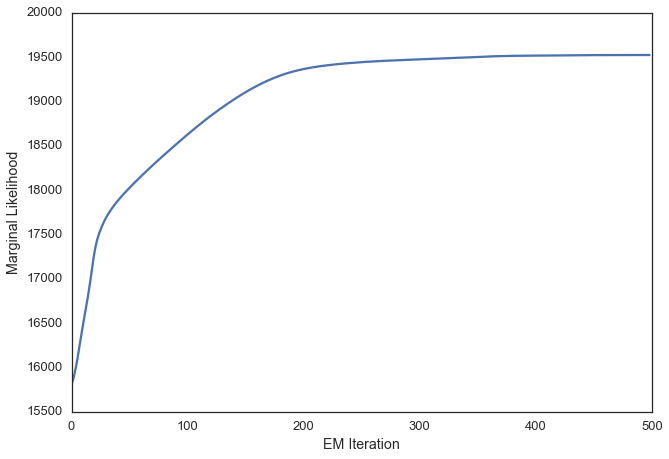

In [35]:
plt.plot(lds_lls[1:])
plt.xlabel("EM Iteration")
plt.ylabel("Marginal Likelihood")

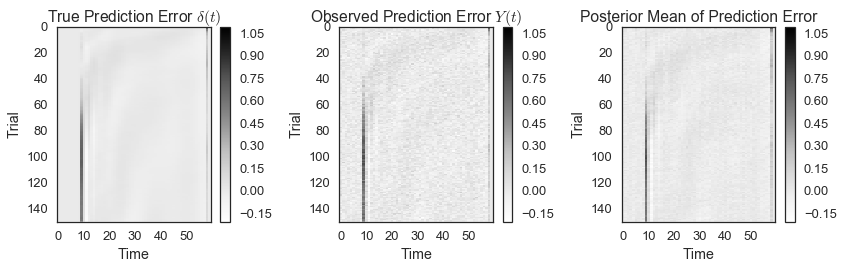

In [36]:
lds_mu_deltas = lds.smooth(Ys, inputs=np.ones((L, 1)))

plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(deltas, aspect="auto", interpolation="none", vmin=-.2, vmax=1.1)
plt.xlabel("Time")
plt.ylabel("Trial")
plt.title("True Prediction Error $\delta(t)$")
plt.colorbar()

plt.subplot(132)
plt.imshow(Ys, aspect="auto", interpolation="none", vmin=-.2, vmax=1.1)
plt.xlabel("Time")
plt.ylabel("Trial")
plt.title("Observed Prediction Error $Y(t)$")
plt.colorbar()

plt.subplot(133)
plt.imshow(lds_mu_deltas, aspect="auto", interpolation="none", vmin=-.2, vmax=1.1)
plt.xlabel("Time")
plt.ylabel("Trial")
plt.title("Posterior Mean of Prediction Error")
plt.colorbar()

plt.tight_layout()

**For example, if we try to interpret the latent states as weights that translate input into value function, we obviously fail. The latent states are invariant to invertible transformation, so we're dead in the water.**

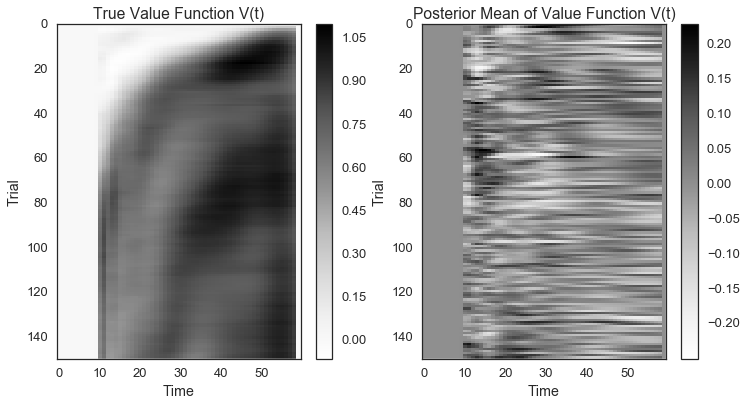

In [37]:
# Compute smoothed estimates of V and delta
lds.states_list[0].E_step()
lds_mu_W = lds.states_list[0].smoothed_mus
lds_Var_W = lds.states_list[0].smoothed_sigmas

lds_mu_V = np.array([lds_mu_W[l].dot(Xs[l].T) for l in range(L)])
lds_sigmasq_V = np.array([np.diag(Xs[l].dot(lds_Var_W[l]).dot(Xs[l].T)) 
                      for l in range(L)])

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(Vs, aspect="auto", interpolation="none")
plt.xlabel("Time")
plt.ylabel("Trial")
plt.title("True Value Function V(t)")
plt.colorbar()

plt.subplot(122)
plt.imshow(lds_mu_V, aspect="auto", interpolation="none")
plt.xlabel("Time")
plt.ylabel("Trial")
plt.title("Posterior Mean of Value Function V(t)")
plt.colorbar()

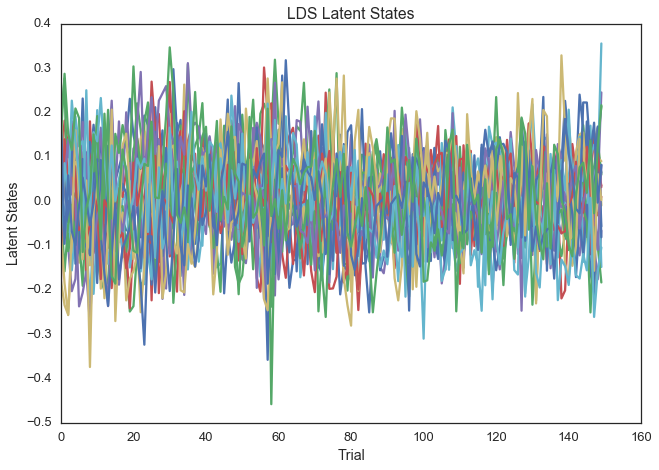

In [38]:
plt.plot(lds_mu_W)
plt.xlabel("Trial")
plt.ylabel("Latent States")
plt.title("LDS Latent States")

# This isn't quite fair -- we didn't give the LDS any knowledge of the inputs, $X$, or the rewards, $R$. 

Below, I let the LDS use $X$ as a linear input signal. Unfortunately, we immediately run into a problem because $X$ is $L \times T \times D$. I raveled $X$ to be $L \times TD$, but that means the input is $TD=1200$ dimensional. We run into some numerical stability issues with inputs this large.


In [39]:
# X_flat = Xs.reshape((L,-1)).copy() # <- This is huge! 60x20 dimensional inputs for each trial!?
# U = np.column_stack((X_flat, np.ones((L,1))))


In [40]:
# D_latent = 4
# D_in = U.shape[1]
# B0 = np.zeros((D_latent, D_in))
# D0 = np.zeros((T, D_in))

# lds = DefaultLDS(T, 4, D_input=U.shape[1], B=B0, D=D0)
# lds.add_data(Ys, inputs=U)

In [41]:
# lls = [lds.log_likelihood()]
# for itr in progprint_xrange(50):
#     lds.EM_step()
#     lls.append(lds.log_likelihood())

In [42]:
# plt.plot(lls[1:])
# plt.xlabel("EM Iteration")
# plt.ylabel("Marginal Likelihood")

In [43]:
# plt.imshow(lds.D, aspect="auto", interpolation="none")
# plt.title("$D$")
# plt.colorbar()

# plt.figure()
# plt.imshow(lds.B, aspect="auto", interpolation="none")
# plt.title("$B$")
# plt.colorbar()

In [44]:
# mu_deltas = lds.smooth(Ys, inputs=U)

# plt.figure(figsize=(12, 4))

# plt.subplot(131)
# plt.imshow(deltas, aspect="auto", interpolation="none", vmin=-.2, vmax=1.1)
# plt.xlabel("Time")
# plt.ylabel("Trial")
# plt.title("True Prediction Error $\delta(t)$")
# plt.colorbar()

# plt.subplot(132)
# plt.imshow(Ys, aspect="auto", interpolation="none", vmin=-.2, vmax=1.1)
# plt.xlabel("Time")
# plt.ylabel("Trial")
# plt.title("Observed Prediction Error $Y(t)$")
# plt.colorbar()

# plt.subplot(133)
# plt.imshow(mu_deltas, aspect="auto", interpolation="none", vmin=-.2, vmax=1.1)
# plt.xlabel("Time")
# plt.ylabel("Trial")
# plt.title("Posterior Mean of Prediction Error")
# plt.colorbar()

# plt.tight_layout()

# Posterior Predictive Checks
Using the fits of the TD-LDS model with constant and power-law learning rates and the unstrucutred LDS from above:
1. Simulate new data (prediction errors) with the inferred alphas and the same inputs ($X$, and $R$)
2. Plot the quantiles of simulated $Y_{l,1:T}$ for different trials, $l$. 

In [45]:
N_sim = 1000
pcts = [5, 25, 50, 75, 95]
N_pcts = len(pcts)

In [46]:
Ys_cnst = []
for itr in range(N_sim):
    _, _, _, Ys_i = simulate_vectorized(Xs, Rs, 
                                        inf_alpha_cnst[-1], inf_gamma_cnst[-1], 
                                        sigma_y, sigma_w)
    Ys_cnst.append(Ys_i)
    
Ys_cnst = np.array(Ys_cnst)
Ys_cnst_pcts = np.percentile(Ys_cnst, pcts, axis=0)

In [47]:
Ys_pwr = []
for itr in range(N_sim):
    _, _, _, Ys_i = simulate_vectorized(Xs, Rs, 
                                        inf_alpha_pwr[-1], inf_gamma_pwr[-1], 
                                        sigma_y, sigma_w)
    Ys_pwr.append(Ys_i)
    
Ys_pwr = np.array(Ys_pwr)
Ys_pwr_pcts = np.percentile(Ys_pwr, pcts, axis=0)

In [48]:
Ys_lds = []
for itr in range(N_sim):
    Ys_i, _ = lds.generate(L, inputs=np.ones((L,1)))
    Ys_lds.append(Ys_i)
    
Ys_lds = np.array(Ys_lds)
Ys_lds_pcts = np.percentile(Ys_lds, pcts, axis=0)

In [49]:
# Helper function to plot asymmetric "sausages"
from matplotlib.patches import Polygon
def asymm_sausage_plot(x, ytop, ybot, sgax=None, **kwargs):
    T = x.size
    assert x.shape == ytop.shape == ybot.shape == (T,)

    # Get axis
    if sgax is None:
        sgax = plt.gca()

    # Compute envelope
    env = np.zeros((T*2,2))
    env[:,0] = np.concatenate((x, x[::-1]))
    env[:,1] = np.concatenate((ytop, ybot[::-1]))

    # Add the patch
    sgax.add_patch(Polygon(env, **kwargs))

In [50]:
# Plot the distribution of Y for a few different trials
def plot_ppc(trial):
    l = trial # Shorten the name    
    plt.figure(figsize=(12,4))
    
    # Plot the percentiles for constant learning rate
    plt.subplot(131)
    ln = plt.plot(np.arange(T), Ys_cnst_pcts[2,l,:], label="50%")[0]
    asymm_sausage_plot(np.arange(T), Ys_cnst_pcts[0,l,:], Ys_cnst_pcts[4,l,:], 
                       color=ln.get_color(), alpha=0.25, 
                       label="{}-{}%".format(pcts[0], pcts[4]))
    asymm_sausage_plot(np.arange(T), Ys_cnst_pcts[1,l,:], Ys_cnst_pcts[3,l,:], 
                       color=ln.get_color(), alpha=0.6,
                       label="{}-{}%".format(pcts[1], pcts[3]))
    
    plt.plot(np.arange(T), Ys[l], '-k', label="data")
    
    plt.ylim(-.2,1)
    plt.xlabel("Time")
    plt.ylabel("$Y_{{ {0},t }}$".format(l))
    plt.title("Trial {} (Constant)".format(l))
    plt.legend(loc="upper left")
    
    # Plot the percentiles for power law learning rate
    plt.subplot(132)
    ln = plt.plot(np.arange(T), Ys_pwr_pcts[2,l,:], label="50%")[0]
    asymm_sausage_plot(np.arange(T), Ys_pwr_pcts[0,l,:], Ys_pwr_pcts[4,l,:], 
                       color=ln.get_color(), alpha=0.25,
                      label="{}-{}%".format(pcts[0], pcts[4]))
    asymm_sausage_plot(np.arange(T), Ys_pwr_pcts[1,l,:], Ys_pwr_pcts[3,l,:], 
                       color=ln.get_color(), alpha=0.5,
                      label="{}-{}%".format(pcts[1], pcts[3]))

    # Plot the data
    plt.plot(np.arange(T), Ys[l], '-k', label="data")
    
    plt.ylim(-.2,1)
    plt.xlabel("Time")
    plt.ylabel("$Y_{{ {0},t }}$".format(l))
    plt.title("Trial {} (Power Law)".format(l))
    plt.legend(loc="upper left")
        
    # Plot the percentiles for unstructured LDS
    plt.subplot(133)
    ln = plt.plot(np.arange(T), Ys_lds_pcts[2,l,:], label="50%")[0]
    asymm_sausage_plot(np.arange(T), Ys_lds_pcts[0,l,:], Ys_lds_pcts[4,l,:], 
                       color=ln.get_color(), alpha=0.25,
                      label="{}-{}%".format(pcts[0], pcts[4]))
    asymm_sausage_plot(np.arange(T), Ys_lds_pcts[1,l,:], Ys_lds_pcts[3,l,:], 
                       color=ln.get_color(), alpha=0.5,
                      label="{}-{}%".format(pcts[1], pcts[3]))

    # Plot the data
    plt.plot(np.arange(T), Ys[l], '-k', label="data")
    
    plt.ylim(-.2,1)
    plt.xlabel("Time")
    plt.ylabel("$Y_{{ {0},t }}$".format(l))
    plt.title("Trial {} (LDS)".format(l))
    plt.legend(loc="upper left")
    
    
    plt.tight_layout()

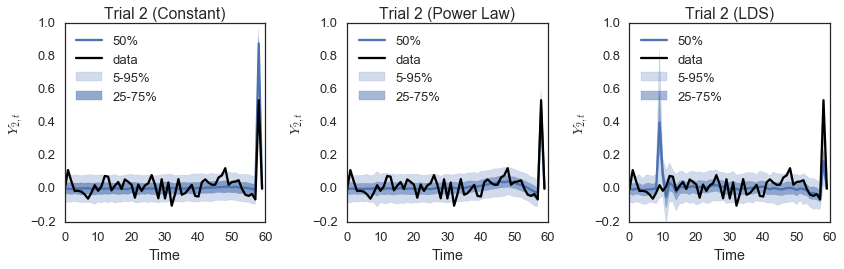

In [51]:
plot_ppc(trial=2)

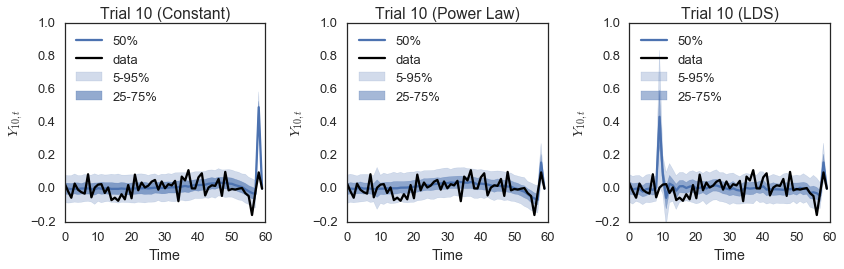

In [52]:
plot_ppc(trial=10)

_Above: The constant learning rate is farthest from the true learning rate in the early trials. This shows up in the PPC for trial 10. Here, the constant model predicts a much larger prediction error from the reward at the end._

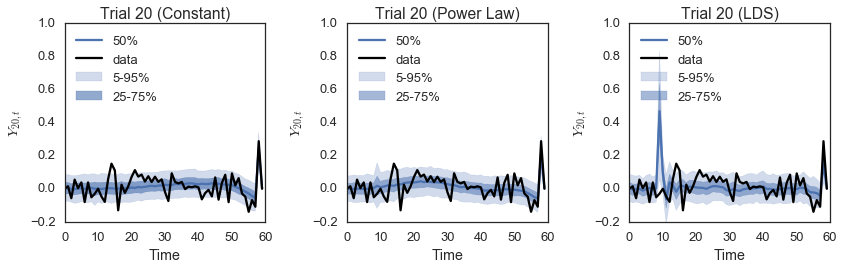

In [53]:
plot_ppc(trial=20)

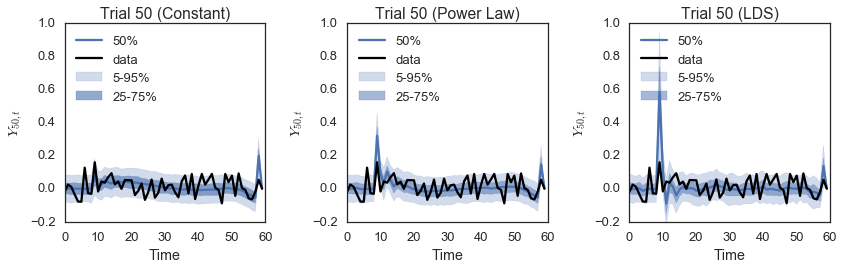

In [54]:
plot_ppc(trial=50)

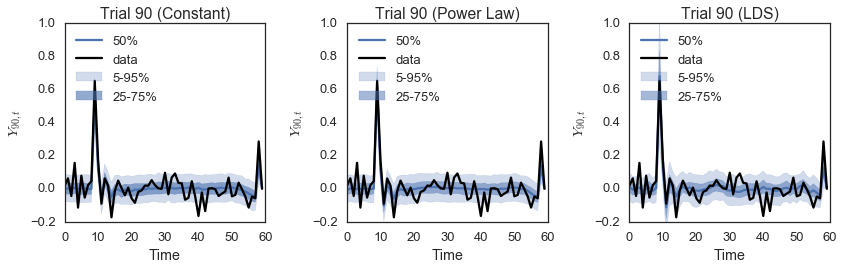

In [55]:
plot_ppc(trial=90)

## Compute something like p values

I'm trying to compute something like the "probability of the data under the empirical distribution of samples." Let's look at each (trial, time bin) pair separately. What is rank-order of the data in this set of simulated values? 

In [56]:
I_cnst = -1 * np.ones((L, T-1))
I_pwr = -1 * np.ones((L, T-1))
I_lds = -1 * np.ones((L, T-1))

for l in range(L):
    for t in range(T-1):
        I_cnst[l,t] = np.sum(Ys_cnst[:,l,t] < Ys[l,t])
        I_pwr[l,t] = np.sum(Ys_pwr[:,l,t] < Ys[l,t])
        I_lds[l,t] = np.sum(Ys_lds[:,l,t] < Ys[l,t])
        
I_cnst /= float(N_sim)
I_pwr /= float(N_sim)
I_lds /= float(N_sim)


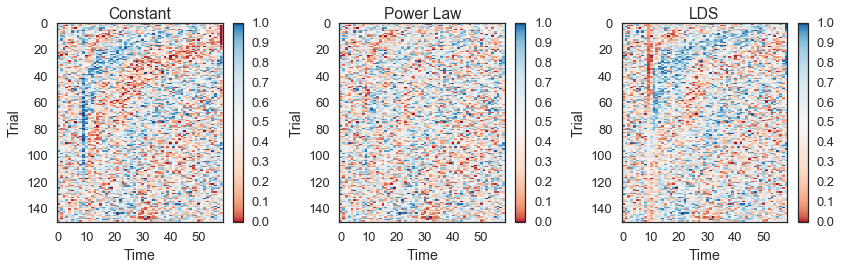

In [57]:
from matplotlib.colors import Normalize
class WarpNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, shrinkage=2.5, clip=False):
        self.shrinkage = shrinkage
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # Exaggerate values close to the boundaries
        # by converting to reals, shrinking toward zero, and converting back
        # This exaggerates the tail values.
        assert np.all(value >= 0)
        assert np.all(value <= 1)
        v = np.clip(value, .001, .999)
        x = np.log(v / (1-v))
        x /= self.shrinkage
        vhat = 1./ (1+np.exp(-x))
        return np.ma.masked_array(vhat)

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(I_cnst, interpolation="none", cmap="RdBu", aspect="auto", norm=WarpNormalize())
# plt.imshow(I_cnst, interpolation="none", cmap="RdBu", aspect="auto")
plt.ylabel("Trial")
plt.xlabel("Time")
plt.title("Constant")
plt.colorbar()

plt.subplot(132)
plt.imshow(I_pwr, interpolation="none", cmap="RdBu", aspect="auto", norm=WarpNormalize())
plt.ylabel("Trial")
plt.xlabel("Time")
plt.title("Power Law")
plt.colorbar()

plt.subplot(133)
plt.imshow(I_lds, interpolation="none", cmap="RdBu", aspect="auto",  norm=WarpNormalize())
plt.ylabel("Trial")
plt.xlabel("Time")
plt.title("LDS")
plt.colorbar()

plt.tight_layout()

_Figure: The fraction of simulated data points that are less than the observed data. If the model had the correct median, we would expect about 50% of the data points to fall below the data. This would correspond to most of the pixels being close to 0.5 (white). We see that the constant learning rate model and the LDS consider the data to be more extreme, as illustrated by the prevalence of dark blue and red values._

_In particular, notice the dark red sliver in the first 20 trials for the constant model!_

# Figures

In [58]:
# Import figure making stuff
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties
import matplotlib.patches as patches
import mpl_toolkits.mplot3d.art3d as art3d

import seaborn as sns
color_names = ["windows blue",
               "red",
               "amber",
               "medium green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "mint",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)
sns.set_style("white")
sns.set_context("paper")

from hips.plotting.colormaps import gradient_cmap
from hips.plotting.layout import create_axis_at_location, remove_plot_labels

# Figure 1
A visual overview of the paper: connecting top-down and bottom-up approaches by translating theories into probabilistic models for neuro-behavioral data, turning the crank of Bayesian inference in order to fit the parameters of these models, and criticizing the model with quantitative, statistical measures. 

In [59]:
# TODO

# Figure 2
Introducing our didactic example: TD-learning as a model for neural data. 
- a. Noisy responses of simulated VTA neuron
- b. Stimulus encoding (x)
- c. Graphical model linear dynamical system with weights as latent states, feedback
- d. Posterior distribution over value function
- e. Posterior distribution of learning rate
- f. Samples of latent states of an unstructured LDS

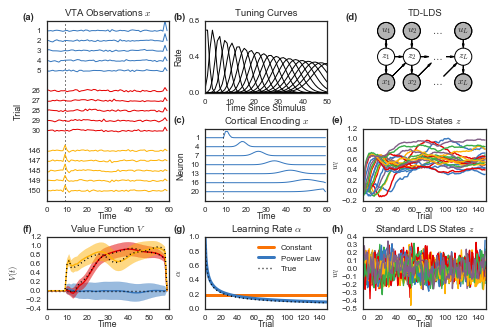

In [62]:
fig = plt.figure(figsize=(6.65,4.75))
# 3 columns of width 2.2 left edges at [0, 2.2, 4.4]
# label pads of 0.5 mean left edges at [0.5, 2.7, 4.9] with width 1.7
# 3 rows of height 1.5. bottom edges at [3, 1.5, 0]
# label pads of 0.5 mean bottom edges at [3.5, 2.0, 0.5] with height 1.0
fp = FontProperties()
fp.set_weight("bold")


# A Noisy responses of simulated VTA neuron 
ns = [0,1,2,3,4,
      25,26,27,28,29,
      145,146,147,148,149]
offsets = [0,-1,-2,-3,-4,
      -6,-7,-8,-9,-10,
      -12,-13,-14,-15,-16]

# ax_a = fig.add_subplot(gs[:4,0])
ax_a = create_axis_at_location(fig, 0.5, 2.0, 1.7, 2.5)
plt.figtext(.025, .95, '(a)', fontproperties=fp)

ax_a.plot([9, 9], [-17, 1], ':k', lw=1, label="stimulus")

for g in range(3):
    for i in range(5):
        ax_a.plot(np.arange(T), Ys[ns[g*5+i]] + offsets[g*5+i], 
                  color=colors[g], lw=1)

ax_a.set_yticks(offsets)
ax_a.set_yticklabels(np.array(ns)+1)
ax_a.set_ylabel("Trial")
ax_a.set_ylim(-17,1)
ax_a.set_xlabel("Time", labelpad=-0.5)
ax_a.set_title("VTA Observations $x$")

# B.1 Temporal tuning curves
plt.figtext(.34, .95, '(b)', fontproperties=fp)
ax_b1 = create_axis_at_location(fig, 2.7, 3.5, 1.7, 1.0)
ax_b1.plot(F, '-k', lw=1)
ax_b1.set_xlabel("Time Since Stimulus", labelpad=-0.5)
ax_b1.set_xlim(0,T-10)
ax_b1.set_ylabel("Rate")
ax_b1.set_yticks([0, 0.4, 0.8])
ax_b1.set_title("Tuning Curves")

# B.2 Cortical response
plt.figtext(.34, .65, '(c)', fontproperties=fp)
ax_b2 = create_axis_at_location(fig, 2.7, 2.0, 1.7, 1.0)

iplt = np.array([0, 3, 6, 9, 12, 15, 19])
ax_b2.plot(X[:,iplt] - np.arange(len(iplt)), color=colors[0], lw=1)
ax_b2.plot([9, 9], [1, -7], ':k', lw=1, label="stimulus")
ax_b2.set_ylabel("Neuron")
ax_b2.set_yticks(0. + np.arange(0, -len(iplt)-1, -1))
ax_b2.set_yticklabels(1 + iplt)
ax_b2.set_xlabel("Time", labelpad=-0.5)
ax_b2.set_title("Cortical Encoding $x$")

# C. The probabilistic graphical model
import daft
ax_c = create_axis_at_location(fig, 4.9, 3.5, 1.7, 1.0, frameon=False, xticks=[], yticks=[], aspect=1.0)
plt.figtext(.7, .95, '(d)', fontproperties=fp)

# Instantiate the PGM.
pgm = daft.PGM([6, 6])
pgm._ctx._figure = fig
pgm._ctx._ax = ax_c

# Cortical encoding
pgm.add_node(daft.Node("x1", r"$u_{1}$",  0.50, 2.00, observed=True))
pgm.add_node(daft.Node("x2", r"$u_{2}$",  1.25, 2.00, observed=True))
pgm.add_node(daft.Node("xh", r"$\ldots$", 2.00, 2.00, observed=True, plot_params=dict(visible=False)))
pgm.add_node(daft.Node("xT", r"$u_{L}$",  2.75, 2.00, observed=True))

# Weights.
pgm.add_node(daft.Node("w1", r"$z_{1}$",  0.50, 1.25))
pgm.add_node(daft.Node("w2", r"$z_{2}$",  1.25, 1.25))
pgm.add_node(daft.Node("wh", r"$\ldots$", 2.00, 1.25, plot_params=dict(visible=False)))
pgm.add_node(daft.Node("wT", r"$z_{L}$",  2.75, 1.25))

# Noisy prediction errors
pgm.add_node(daft.Node("y1", r"$x_{1}$",  0.50, 0.50, observed=True))
pgm.add_node(daft.Node("y2", r"$x_{2}$",  1.25, 0.50, observed=True))
pgm.add_node(daft.Node("yh", r"$\ldots$", 2.00, 0.50, observed=True, plot_params=dict(visible=False)))
pgm.add_node(daft.Node("yT", r"$x_{L}$",  2.75, 0.50, observed=True))

# Add in the edges.
pgm.add_edge("x1", "w1")
pgm.add_edge("x2", "w2")
pgm.add_edge("xT", "wT")

pgm.add_edge("w1", "w2")
pgm.add_edge("w2", "wh")
pgm.add_edge("wh", "wT")

pgm.add_edge("w1", "y1")
pgm.add_edge("w2", "y2")
pgm.add_edge("wT", "yT")

pgm.add_edge("y1", "w2")
pgm.add_edge("y2", "wh")
pgm.add_edge("yh", "wT")

pgm.render()
ax_c.set_xlim(0.4, 6.1)
ax_c.set_ylim(0.4, 4.6)
ax_c.set_title("TD-LDS")

# D. Posterior over value function
ax_d = create_axis_at_location(fig, 0.5, 0.5, 1.7, 1.0)
plt.figtext(.025, .33, '(f)', fontproperties=fp)

# Plot slices of the value function with marginal variance
from hips.plotting.sausage import sausage_plot
for i,l in enumerate([0, 25, 149]):
    ax_d.plot(pwr_mu_V[l], color=colors[i], label="trial {}".format(l))
    sausage_plot(np.arange(T), pwr_mu_V[l], np.sqrt(pwr_sigmasq_V[l]), 
                 color=colors[i], alpha=0.5, sgax=ax_d)
    ax_d.plot(Vs[l], ':k')

ax_d.set_ylabel("$V(t)$")
ax_d.set_xlabel("Time", labelpad=-0.5)
ax_d.set_title("Value Function $V$")

# E. True and inferred learning rate
ax_e = create_axis_at_location(fig, 2.7, 0.5, 1.7, 1.0)
plt.figtext(.34, .33, '(g)', fontproperties=fp)
ax_e.plot(inf_alpha_cnst[-1], color=colors[5], lw=3, label="Constant")
ax_e.plot(inf_alpha_pwr[-1], color=colors[0], lw=3, label="Power Law")
ax_e.plot(alpha, ':k', label="True")
ax_e.set_xlabel("Trial", labelpad=-0.5)
ax_e.set_xlim(0,L)
ax_e.set_ylabel("$\\alpha$")
ax_e.set_title("Learning Rate $\\alpha$")
plt.legend(loc="upper right")

# F. Latent states
plt.figtext(.67, .65, '(e)', fontproperties=fp)
ax_f1 = create_axis_at_location(fig, 4.9, 2.0, 1.7, 1.0)
for d in range(D):
    ax_f1.plot(pwr_mu_W[:,d], color=colors[d%5])
ax_f1.set_xlabel("Trial", labelpad=-0.5)
ax_f1.set_xlim(0, L)
ax_f1.set_ylabel("$w_l$", labelpad=-0.5)
ax_f1.set_title("TD-LDS States $z$")


plt.figtext(.67, .33, '(h)', fontproperties=fp)
ax_f2 = create_axis_at_location(fig, 4.9, 0.5, 1.7, 1.0)
for d in range(D):
    ax_f2.plot(lds_mu_W[:,d], color=colors[d%5])
ax_f2.set_xlabel("Trial", labelpad=-0.5)
ax_f2.set_xlim(0, L)
ax_f2.set_ylabel("$w_l$", labelpad=-0.5)
ax_f2.set_title("Standard LDS States $z$")

plt.savefig("tdlearning.pdf")

# Figure 3: Model Checking and Comparison

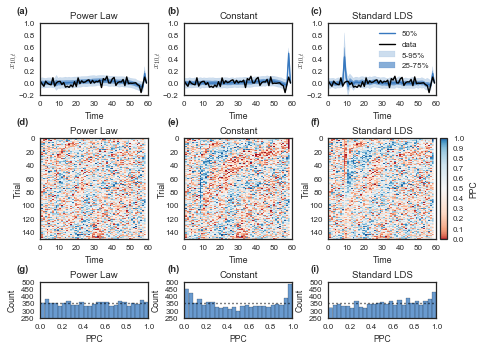

In [66]:
fig = plt.figure(figsize=(6.65, 4.75))

fp = FontProperties()
fp.set_weight("bold")

def _plot_single_ppc(l, yy_pcts, title, legend=False):
    plt.plot(np.arange(T), yy_pcts[2,l,:], color=colors[0], label="50%")
    asymm_sausage_plot(np.arange(T), yy_pcts[0,l,:], yy_pcts[4,l,:], 
                       color=colors[0], alpha=0.25, 
                       label="{}-{}%".format(pcts[0], pcts[4]))
    asymm_sausage_plot(np.arange(T), yy_pcts[1,l,:], yy_pcts[3,l,:], 
                       color=colors[0], alpha=0.6,
                       label="{}-{}%".format(pcts[1], pcts[3]))

    plt.plot(np.arange(T), Ys[l], '-k', label="data")
    
    plt.ylim(-.2,1)
    plt.xlabel("Time")
    plt.ylabel("$x_{{ {0},t }}$".format(l), labelpad=-1)
    plt.title(title)
    if legend:
        plt.legend(loc="upper right")


# A Power law PPC
ax_a = create_axis_at_location(fig, 0.5, 3.5, 1.5, 1.0)
plt.figtext(.025, .975, '(a)', fontproperties=fp)
_plot_single_ppc(10, Ys_pwr_pcts, "Power Law")

# B. Constant PPC
ax_b1 = create_axis_at_location(fig, 2.5, 3.5, 1.5, 1.0)
plt.figtext(.34, .975, '(b)', fontproperties=fp)
_plot_single_ppc(10, Ys_cnst_pcts, "Constant")

# C. LDS PPC
ax_c = create_axis_at_location(fig, 4.5, 3.5, 1.5, 1.0)
plt.figtext(.64, .975, '(c)', fontproperties=fp)
_plot_single_ppc(10, Ys_lds_pcts, "Standard LDS", legend=True)

# D. Power law PPC
ax_d = create_axis_at_location(fig, 0.5, 1.5, 1.5, 1.4)
plt.figtext(.025, .65, '(d)', fontproperties=fp)
im_d = ax_d.imshow(I_pwr, interpolation="none", cmap="RdBu", aspect="auto", norm=WarpNormalize())
ax_d.set_ylabel("Trial", labelpad=-2)
ax_d.set_xlabel("Time")
ax_d.set_xlim(0,60)
ax_d.set_title("Power Law")

# E. Constant PPC
ax_e = create_axis_at_location(fig, 2.5, 1.5, 1.5, 1.4)
plt.figtext(.34, .65, '(e)', fontproperties=fp)
im_e = ax_e.imshow(I_cnst, interpolation="none", cmap="RdBu", aspect="auto", norm=WarpNormalize())
ax_e.set_ylabel("Trial", labelpad=-2)
ax_e.set_xlabel("Time")
ax_e.set_xlim(0,60)
ax_e.set_title("Constant")

# F. Latent states
plt.figtext(.64, .65, '(f)', fontproperties=fp)
ax_f = create_axis_at_location(fig, 4.5, 1.5, 1.5, 1.4)
im_f = ax_f.imshow(I_lds, interpolation="none", cmap="RdBu", aspect="auto", norm=WarpNormalize())
ax_f.set_ylabel("Trial", labelpad=-2)
ax_f.set_xlabel("Time")
ax_f.set_xlim(0,60)
ax_f.set_title("Standard LDS")

cbax = create_axis_at_location(fig, 6.05, 1.5, 0.1, 1.4)
plt.colorbar(im_f, cax=cbax, label="PPC")

# G. Power law PPC histogram
nbins = 25

plt.figtext(.025, .22, '(g)', fontproperties=fp)
ax_g = create_axis_at_location(fig, .5, .4, 1.5, .5)
ax_g.hist(np.ravel(I_pwr), nbins, normed=False, color=colors[0], alpha=0.75)
ax_g.plot([0,1], I_pwr.size / float(nbins) * np.ones(2), ':k')
ax_g.set_ylim(250,500)
ax_g.set_ylabel("Count")
ax_g.set_xlabel("PPC")
ax_g.set_title("Power Law")

plt.figtext(.34, .22, '(h)', fontproperties=fp)
ax_h = create_axis_at_location(fig, 2.5, .4, 1.5, .5)
ax_h.hist(np.ravel(I_cnst), nbins, normed=False, color=colors[0], alpha=0.75)
ax_h.plot([0,1], I_cnst.size / float(nbins) * np.ones(2), ':k')
ax_h.set_ylim(250,500)
ax_h.set_ylabel("Count")
ax_h.set_xlabel("PPC")
ax_h.set_title("Constant")

plt.figtext(.64, .22, '(i)', fontproperties=fp)
ax_i = create_axis_at_location(fig, 4.5, .4, 1.5, .5)
ax_i.hist(np.ravel(I_lds), nbins, normed=False, color=colors[0], alpha=0.75)
ax_i.plot([0,1], I_lds.size / float(nbins) * np.ones(2), ':k')
ax_i.set_ylim(250,500)
ax_i.set_ylabel("Count")
ax_i.set_xlabel("PPC")
ax_i.set_title("Standard LDS")

plt.savefig("ppcs.pdf")